In [1]:
!nvidia-smi

Mon Oct 28 12:39:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   41C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
# Check TensorFlow for GPU
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"  - {gpu}")
else:
    print("No GPU, TensorFlow uses CPU.")

  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
import os
import IPython

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
import warnings

warnings.filterwarnings('ignore')

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
output_dir = '/content/drive/MyDrive/DataSet/ML hw'

dataset, info = tfds.load(
    "oxford_iiit_pet",
    data_dir=output_dir,
    with_info=True,
    as_supervised=True,
    download=True,
    shuffle_files=True
)

IPython.display.clear_output()

In [13]:
train_dataset = dataset['train']
test_dataset = dataset['test']

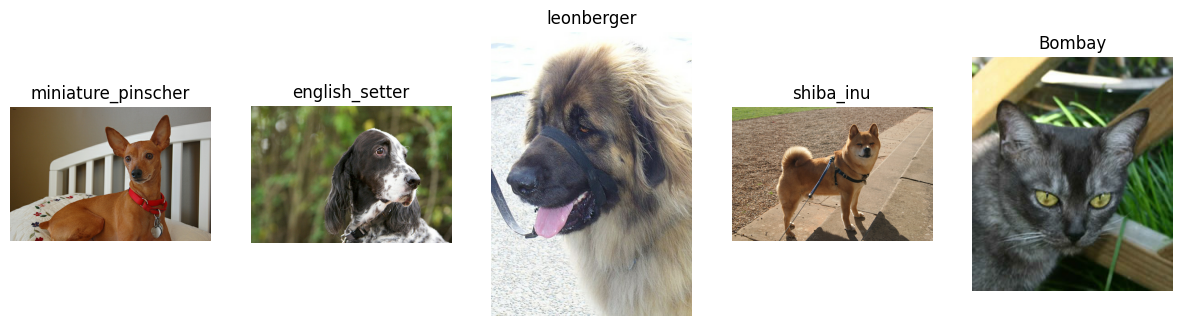

In [6]:
def show_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i, (image, label) in enumerate(dataset.take(num_samples)):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        class_name = info.features['label'].int2str(label.numpy())
        plt.title(class_name)
        plt.axis('off')
    plt.show()

show_samples(train_dataset, num_samples=5)

In [14]:
image_size = 32
# data augmentation
import random

def augment_image(image, label):
    image = tf.image.resize(image, (image_size, image_size))
    image = tf.cast(image, tf.float32) / 255.0
    # list of augmentation functions
    augmentation_funcs = [
        tf.image.random_brightness,
        tf.image.random_contrast,
        tf.image.random_hue,
        tf.image.random_saturation,
        tf.image.random_flip_left_right,
        tf.image.random_flip_up_down,
        tf.image.random_crop,
        tf.image.random_jpeg_quality,
        tf.image.random_flip_up_down,
        tf.image.random_flip_left_right,
        tf.image.random_saturation,
        tf.image.adjust_brightness,
        tf.image.adjust_contrast,
        tf.image.adjust_gamma,
        tf.image.adjust_hue,
        tf.image.adjust_saturation,
        tf.image.central_crop,
        tf.image.extract_glimpse,
        tf.image.crop_and_resize,
        tf.image.resize_with_crop_or_pad,
        tf.image.rot90,
        tf.image.transpose
    ]

    # Random one augmentation function
    chosen_func = random.choice(augmentation_funcs)

    # Apply augmentation function
    if chosen_func in [tf.image.random_brightness, tf.image.random_contrast,
                       tf.image.random_hue, tf.image.random_saturation,
                       tf.image.adjust_brightness, tf.image.adjust_contrast,
                       tf.image.adjust_gamma, tf.image.adjust_hue,
                       tf.image.adjust_saturation]:

        max_delta = 0.1
        image = chosen_func(image, max_delta=max_delta)
    elif chosen_func == tf.image.random_crop:
        image = tf.image.random_crop(image, size=[image.shape[0] // 2, image.shape[1] // 2, image.shape[2]])
    elif chosen_func in [tf.image.crop_and_resize, tf.image.central_crop]:
        image = tf.image.central_crop(image, central_fraction=0.5)
    elif chosen_func in [tf.image.rot90, tf.image.transpose]:
        image = chosen_func(image)
    else:
        image = chosen_func(image)

    return image, label


In [19]:
repeat_fac = 4
# augment the dataset
train_ds = dataset['train'].repeat(repeat_fac)
train_d = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dr = train_d.prefetch(tf.data.AUTOTUNE)

In [21]:
test_ds = dataset['test'].repeat(repeat_fac)
test_d = test_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dr = test_d.prefetch(tf.data.AUTOTUNE)

In [22]:
def conv2ndarray(tdarray):
    x = []
    y = []
    for xi, label in tdarray:
        x.append(xi)
        y.append(label)
    return np.array(x), np.array(y)

x1, y1 = conv2ndarray(train_dr)
# del train_ds # Remove train_ds, test_ds to clear GPU memory.
x2, y2 = conv2ndarray(test_dr)
# del test_ds # Remove train_ds, test_ds to clear GPU memory.

In [24]:
x1.shape, x2.shape, y1.shape, y2.shape

((14720, 32, 32, 3), (14676, 32, 32, 3), (14720,), (14676,))

In [25]:
x = np.concatenate([x1, x2], axis=0)
y = np.concatenate([y1, y2], axis=0)

In [26]:
x.shape, y.shape

((29396, 32, 32, 3), (29396,))

In [27]:
y = tf.keras.utils.to_categorical(y, num_classes=37)
y.shape

(29396, 37)

In [28]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# # Clear x, y for memory space
# del x
# del y

In [32]:
from keras.applications import ResNet50V2
from keras.layers import Flatten, Dense
from keras.models import Model


base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained ResNet50V2 model
for layer in base_model.layers:
    layer.trainable = False

In [35]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [36]:
# Train model
model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.0750 - loss: 3.5043 - val_accuracy: 0.1448 - val_loss: 3.2251
Epoch 2/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2184 - loss: 3.0032 - val_accuracy: 0.1976 - val_loss: 3.0424
Epoch 3/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3032 - loss: 2.6723 - val_accuracy: 0.2364 - val_loss: 2.9135
Epoch 4/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3749 - loss: 2.4116 - val_accuracy: 0.2727 - val_loss: 2.8078
Epoch 5/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4211 - loss: 2.2244 - val_accuracy: 0.3111 - val_loss: 2.7184
Epoch 6/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4723 - loss: 2.0537 - val_accuracy: 0.3355 - val_loss: 2.6576
Epoch 7/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5136 - loss: 1.9027 - val_accuracy: 0.3659 - val_loss: 2.6111
Epoch 8/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5464 - loss: 1.7745 - val_ac

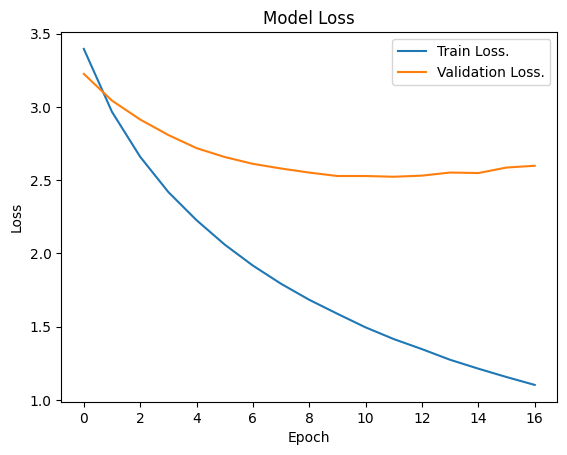

In [37]:
plt.plot(model.history.history['loss'], label='Train Loss.')
plt.plot(model.history.history['val_loss'], label='Validation Loss.')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
!pip install keras_tuner
IPython.display.clear_output()

In [39]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((20577, 32, 32, 3), (20577, 37), (8819, 32, 32, 3), (8819, 37))

In [43]:
# RestNet Hyperparameter Tunning

import keras_tuner as kt

def build_model(hp):
  base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

  x = base_model.output
  x = GlobalMaxPooling2D()(x)

  units = hp.Int('units', min_value=32, max_value=512, step=32)
  x = Dense(units, activation='relu')(x)

  predictions = Dense(info.features['label'].num_classes, activation='softmax')(x)

  model = Model(inputs=base_model.input, outputs=predictions)

  # Freeze the layers of the pre-trained ResNet50V2 model
  for layer in base_model.layers:
    layer.trainable = False

  # Tune the learning rate for the optimizer
  learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model


tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='/content/drive/MyDrive/DataSet/RestNetTunning1',
    project_name='intro_to_kt'
)


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(
    x_train, y_train,
    epochs=30,
    validation_data=(x_test, y_test),
    callbacks=[stop_early]
)


# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the
dense layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Trial 5 Complete [00h 03m 20s]
val_accuracy: 0.5237555106480917

Best val_accuracy So Far: 0.5604565938313802
Total elapsed time: 00h 21m 28s

The optimal number of units in the 
dense layer is 480 and the optimal learning rate for the optimizer
is 0.01.



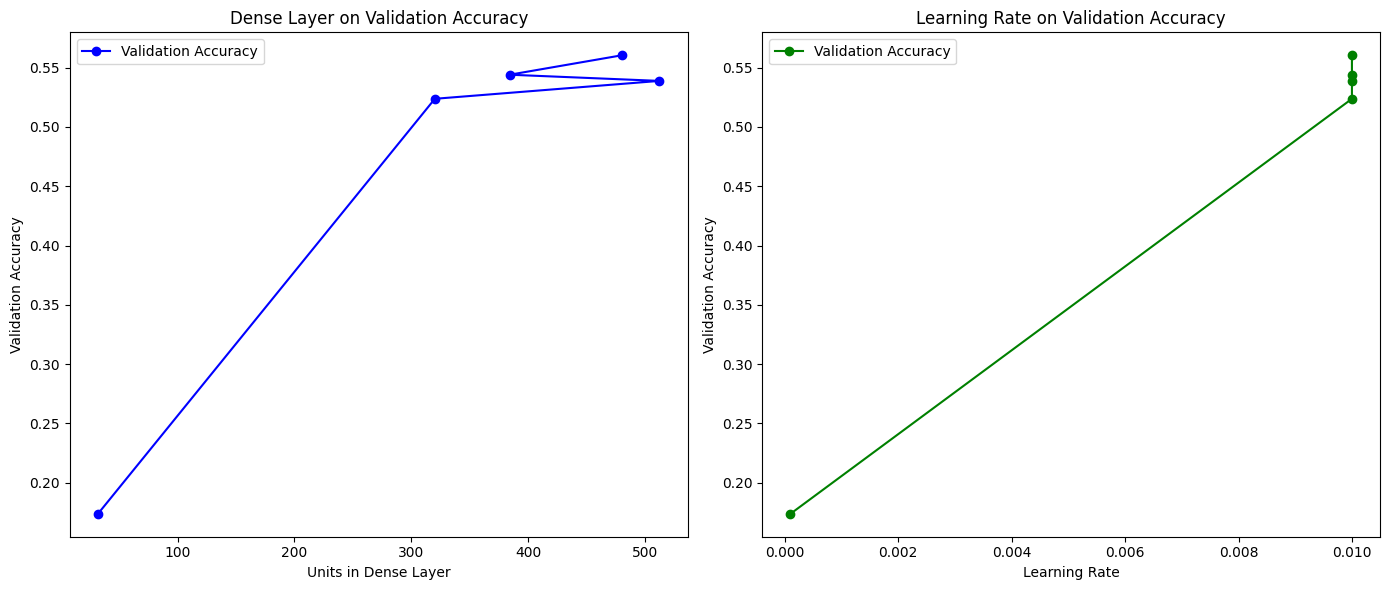

In [49]:
import matplotlib.pyplot as plt

best_trials = tuner.oracle.get_best_trials(num_trials=5)

units_values = []
learning_rates = []
val_accuracies = []

for trial in best_trials:
    units = trial.hyperparameters.get('units')
    learning_rate = trial.hyperparameters.get('learning_rate')

    val_accuracy = trial.metrics.get_best_value('val_accuracy')

    units_values.append(units)
    learning_rates.append(learning_rate)
    val_accuracies.append(val_accuracy)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(units_values, val_accuracies, c='blue', label='Validation Accuracy', marker='o')
plt.xlabel('Units in Dense Layer')
plt.ylabel('Validation Accuracy')
plt.title('Dense Layer on Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(learning_rates, val_accuracies, c='green', label='Validation Accuracy', marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Learning Rate on Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [100]:
# Train Tuning Model
best_model = tuner.hypermodel.build(best_hps)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

best_model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[stop_early])

Epoch 1/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.0848 - loss: 3.6052 - val_accuracy: 0.1476 - val_loss: 3.3335
Epoch 2/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2284 - loss: 2.9683 - val_accuracy: 0.2322 - val_loss: 3.0896
Epoch 3/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.3723 - loss: 2.3848 - val_accuracy: 0.3071 - val_loss: 2.9014
Epoch 4/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4836 - loss: 1.9435 - val_accuracy: 0.3786 - val_loss: 2.8483
Epoch 5/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5590 - loss: 1.6447 - val_accuracy: 0.4235 - val_loss: 2.9266
Epoch 6/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6301 - loss: 1.3903 - val_accuracy: 0.4614 - val_loss: 3.0203
Epoch 7/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6724 - loss: 1.2074 - val_accuracy: 0.4859 - val_loss: 3.2501
Epoch 8/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7144 - loss: 1.0745 - val_accuracy: 

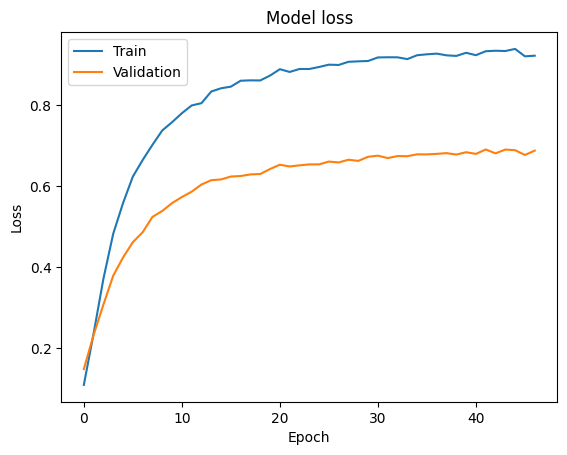

In [101]:
plt.plot(best_model.history.history['accuracy'])
plt.plot(best_model.history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [102]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for both models (before and after tuning)
y_pred_before = model.predict(x_test)
y_pred_before = np.argmax(y_pred_before, axis=1)
y_true = np.argmax(y_test, axis=1)


y_pred_after = best_model.predict(x_test)
y_pred_after = np.argmax(y_pred_after, axis=1)


# Calculate confusion matrices
cm_before = confusion_matrix(y_true, y_pred_before)
cm_after = confusion_matrix(y_true, y_pred_after)

276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
276/276 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step


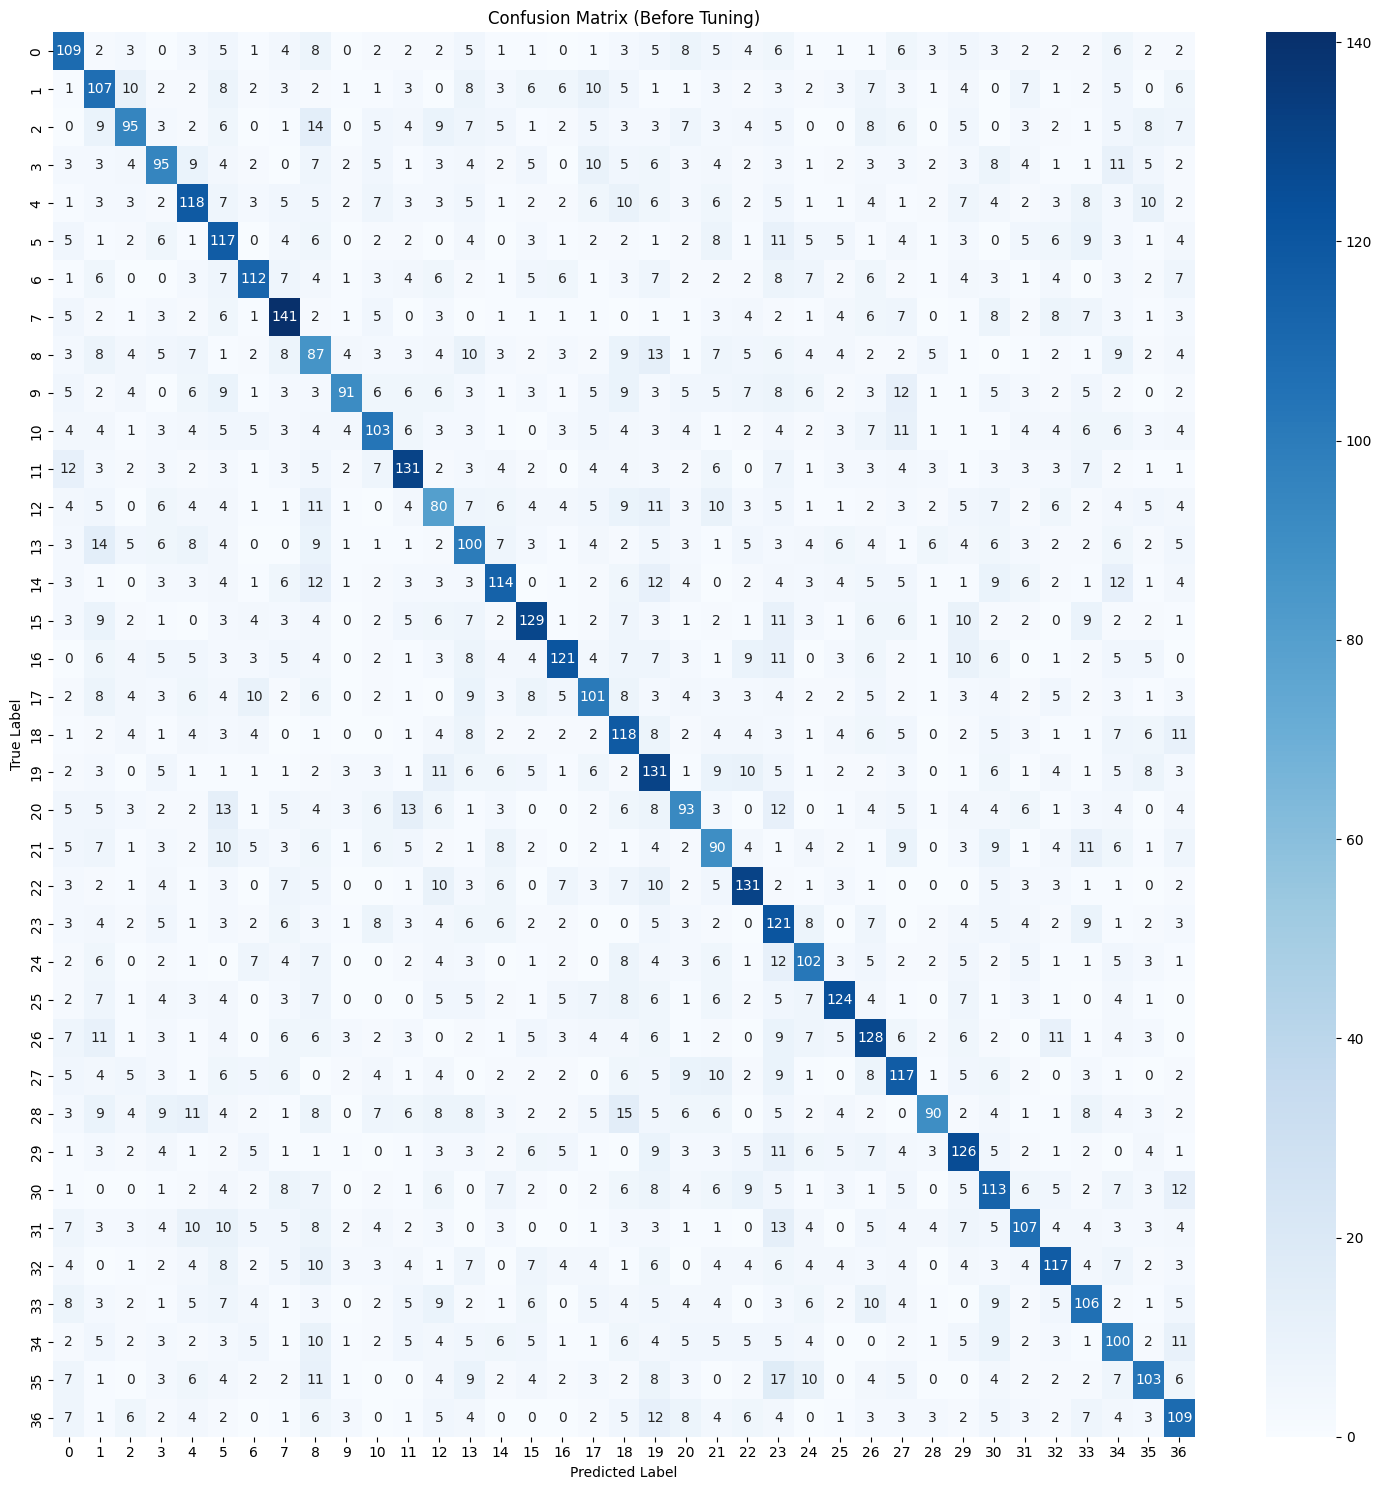

In [103]:
# Plotting confusion matrices before Tune
plt.figure(figsize=(15, 15))

sns.heatmap(cm_before, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Before Tuning)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


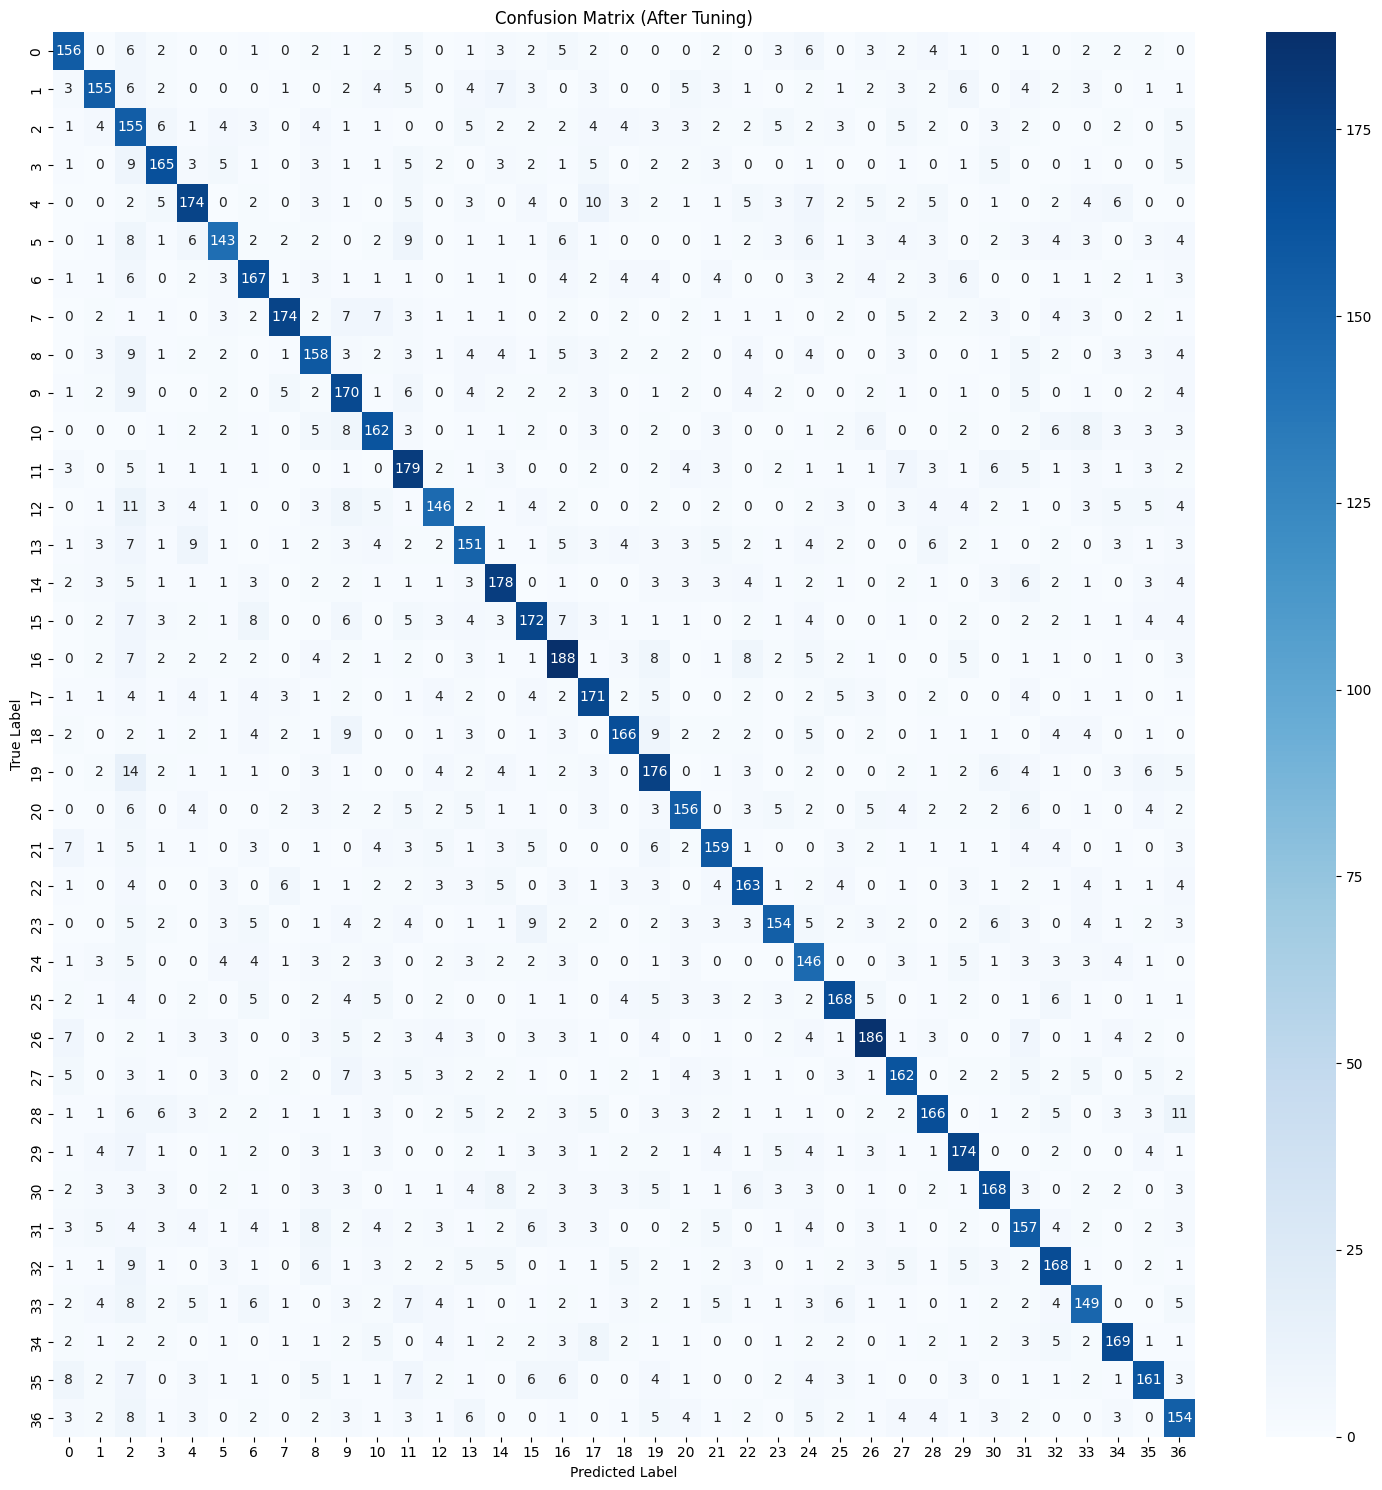

In [104]:
# After Tune Confusion Matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (After Tuning)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [105]:
# Before Tune Classification Report
from sklearn.metrics import classification_report

y_pred_before = model.predict(x_test)
y_pred_before = np.argmax(y_pred_before, axis=1)
y_true = np.argmax(y_test, axis=1)
report_before = classification_report(y_true, y_pred_before)


print("Classification Report (Before Tuning)\n")
print(report_before)

276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report (Before Tuning)

              precision    recall  f1-score   support

           0       0.46      0.50      0.48       216
           1       0.40      0.46      0.43       231
           2       0.52      0.40      0.45       238
           3       0.46      0.42      0.44       228
           4       0.48      0.46      0.47       258
           5       0.40      0.51      0.45       228
           6       0.56      0.48      0.51       235
           7       0.53      0.59      0.56       238
           8       0.29      0.37      0.33       237
           9       0.67      0.39      0.49       236
          10       0.50      0.44      0.47       232
          11       0.56      0.53      0.54       246
          12       0.35      0.34      0.35       232
          13       0.38      0.42      0.40       239
          14       0.52      0.47      0.49       244
          15       0.56      0.51      0.53       253
 

In [106]:
# After Tune Classification Report
y_pred_after = best_model.predict(x_test)
y_pred_after = np.argmax(y_pred_after, axis=1)
report_after = classification_report(y_true, y_pred_after)
print("\nClassification Report (After Tuning)\n")
print(report_after)

276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report (After Tuning)

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       216
           1       0.74      0.67      0.70       231
           2       0.43      0.65      0.52       238
           3       0.74      0.72      0.73       228
           4       0.71      0.67      0.69       258
           5       0.71      0.63      0.67       228
           6       0.70      0.71      0.71       235
           7       0.85      0.73      0.79       238
           8       0.65      0.67      0.66       237
           9       0.63      0.72      0.67       236
          10       0.68      0.70      0.69       232
          11       0.64      0.73      0.68       246
          12       0.71      0.63      0.67       232
          13       0.63      0.63      0.63       239
          14       0.71      0.73      0.72       244
          15       0.70      0.68      0.69       253
 

In [107]:
# Evaluation Matrix before Tune and After Tune
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_before = accuracy_score(y_true, y_pred_before)
precision_before = precision_score(y_true, y_pred_before, average='weighted')
recall_before = recall_score(y_true, y_pred_before, average='weighted')
f1_before = f1_score(y_true, y_pred_before, average='weighted')

accuracy_after = accuracy_score(y_true, y_pred_after)
precision_after = precision_score(y_true, y_pred_after, average='weighted')
recall_after = recall_score(y_true, y_pred_after, average='weighted')
f1_after = f1_score(y_true, y_pred_after, average='weighted')

evaluation_matrix = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Before Tuning': [accuracy_before, precision_before, recall_before, f1_before],
    'After Tuning': [accuracy_after, precision_after, recall_after, f1_after]
})

evaluation_matrix

,Metric,Before Tuning,After Tuning
0,Accuracy,0.462297,0.687833
1,Precision,0.475472,0.694613
2,Recall,0.462297,0.687833
3,F1-Score,0.464114,0.689560


In [108]:
# function to show image correct predict and incorrect predict
def show_true_false_pred(x_test, y_test, y_pred, class_names, num_samples=5):
    """
    Shows random images with their true and predicted labels, highlighting false predictions.

    Args:
        x_test: Test data (images).
        y_test: True labels.
        y_pred: Predicted labels.
        class_names: List of class names.
        num_samples: Number of samples to display.
    """
    random_indices = np.random.choice(len(x_test), num_samples, replace=False)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_test[idx])
        true_label = class_names[y_test[idx]]
        pred_label = class_names[y_pred[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}", color="green" if y_test[idx] == y_pred[idx] else "red")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

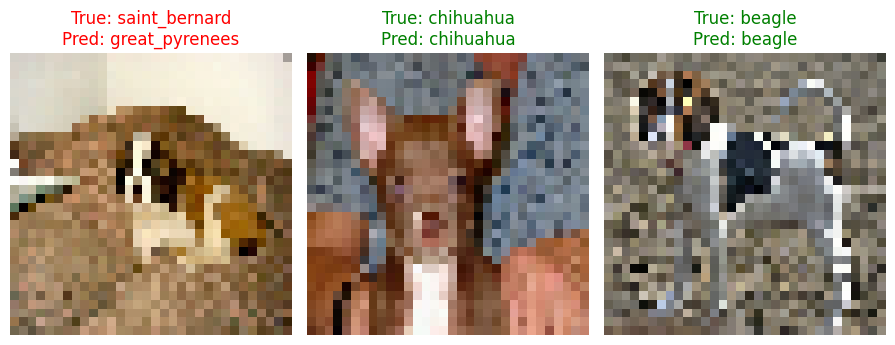

In [112]:
# call function
class_names = info.features['label'].names
nums = 3
show_true_false_pred(x_test, np.argmax(y_test, axis=1), y_pred_after, class_names, num_samples=nums)

# Compareision Model CNN and RestNet

In [113]:
conv_model = tf.keras.models.load_model('/content/drive/MyDrive/DataSet/Model/conv_best_model.h5')

276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


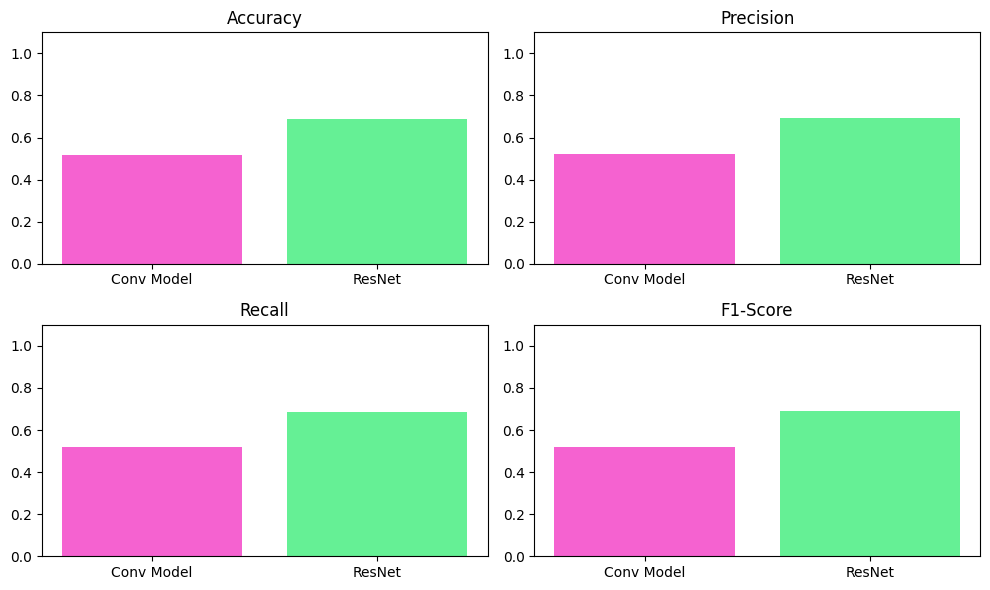

In [116]:
y_pred_conv = conv_model.predict(x_test)
y_pred_conv = np.argmax(y_pred_conv, axis=1)

accuracy_conv = accuracy_score(y_true, y_pred_conv)
precision_conv = precision_score(y_true, y_pred_conv, average='weighted')
recall_conv = recall_score(y_true, y_pred_conv, average='weighted')
f1_conv = f1_score(y_true, y_pred_conv, average='weighted')


evaluation_matrix_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Conv Model': [accuracy_conv, precision_conv, recall_conv, f1_conv],
    'ResNet': [accuracy_after, precision_after, recall_after, f1_after]
})

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.bar(['Conv Model', 'ResNet'],
            [evaluation_matrix_comparison.loc[evaluation_matrix_comparison['Metric'] == metric, 'Conv Model'].iloc[0],
             evaluation_matrix_comparison.loc[evaluation_matrix_comparison['Metric'] == metric, 'ResNet'].iloc[0]],
            color=['#f562d0', '#65f095'])
    plt.title(metric)
    plt.ylim([0, 1.1])

plt.tight_layout()
plt.show()

In [117]:
# Evaluation Matrics
evaluation_matrix_comparison

,Metric,Conv Model,ResNet
0,Accuracy,0.517179,0.687833
1,Precision,0.523590,0.694613
2,Recall,0.517179,0.687833
3,F1-Score,0.517386,0.689560
